In [4]:
import glob
from importlib import reload

#import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pywt
import scipy as sp
import seaborn as sns
#import sklearn as skl
import utm
import xarray as xr
#from eofs.xarray import Eof
#import dask
from matplotlib import style
from matplotlib.dates import date2num, num2date
#from pyts.image import RecurrencePlot
from sklearn.utils.extmath import randomized_svd
#from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.tsa.seasonal import STL
from utide import reconstruct, solve
from windrose import WindroseAxes
from mpl_toolkits.basemap import Basemap

#import EOF_funcs
#import GA_cofin

In [3]:
NWS=xr.open_dataset('Data/2021/NWS_focused.nc')
NK800=xr.open_dataset('Data/2021/NK800_focused.nc')

In [6]:
NWS

<xarray.Dataset>
Dimensions:  (time: 1464, lat: 147, lon: 98)
Coordinates:
    depth    float32 ...
  * lon      (lon) float32 3.03 3.061 3.091 3.121 ... 5.879 5.909 5.939 5.97
  * time     (time) datetime64[ns] 2021-06-01 ... 2021-07-31T23:00:00
  * lat      (lat) float32 59.01 59.03 59.04 59.05 ... 60.95 60.96 60.97 60.99
Data variables:
    vo       (time, lat, lon) float32 ...
    uo       (time, lat, lon) float32 ...
Attributes: (12/15)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    _CoordSysBuilder:     ucar.nc2.dataset.conv.CF1Convention
    comment:

In [4]:
NK800

<xarray.Dataset>
Dimensions:      (time: 1464, Y: 305, X: 340)
Coordinates:
  * X            (X) float64 1.472e+05 1.48e+05 ... 4.176e+05 4.184e+05
  * Y            (Y) float64 3.344e+05 3.352e+05 ... 5.768e+05 5.776e+05
    depth        float64 ...
  * time         (time) datetime64[ns] 2021-06-01 ... 2021-07-31T23:00:00
    lat          (Y, X) float64 ...
    lon          (Y, X) float64 ...
Data variables:
    u_eastward   (time, Y, X) float32 ...
    v_northward  (time, Y, X) float32 ...
Attributes: (12/33)
    file:                            /home/metno_op/run/norkyst-800m_2017/oce...
    type:                            ROMS/TOMS history file
    title:                           NorKyst-800m - ROMS
    var_info:                        /home/metno_op/sea/ROMS/metroms/apps/com...
    rst_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    his_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    ...                              ...
    history:                         Tue Jun  1 17:15:38 2021: ncks -O --4 -d...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     NORKYST800M, ADD_FSOBC, ADD_M2OBC, ALBED...
    Conventions:                     CF-1.4, SGRID-0.3
    NCO:                             netCDF Operators version 4.8.0 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [12]:
NKs=NK800.stack(z=['Y','X']).dropna('z')
NWSs=NWS.stack(z=['lat','lon']).dropna(dim='z')

In [13]:
NWSs

<xarray.Dataset>
Dimensions:  (time: 1464, z: 10678)
Coordinates:
    depth    float32 0.0
  * time     (time) datetime64[ns] 2021-06-01 ... 2021-07-31T23:00:00
  * z        (z) MultiIndex
  - lat      (z) float64 59.01 59.01 59.01 59.01 ... 60.99 60.99 60.99 60.99
  - lon      (z) float64 3.03 3.061 3.091 3.121 ... 4.667 4.727 4.758 4.788
Data variables:
    vo       (time, z) float32 -0.028 0.001 0.065 0.143 ... -0.24 -0.425 -0.377
    uo       (time, z) float32 0.031 0.008 0.011 0.024 ... -0.075 -0.272 -0.222
Attributes: (12/15)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    _CoordSysBuilder:     ucar.nc2.dataset.conv.CF1Convention
    comment:

In [17]:
NKs

<xarray.Dataset>
Dimensions:      (time: 1464, z: 45697)
Coordinates:
    depth        float64 0.0
  * time         (time) datetime64[ns] 2021-06-01 ... 2021-07-31T23:00:00
    lat          (z) float64 59.01 59.01 59.0 59.01 ... 60.99 60.99 60.99 61.0
    lon          (z) float64 5.989 5.995 5.97 5.976 ... 3.017 3.023 3.004 3.009
  * z            (z) MultiIndex
  - Y            (z) float64 3.344e+05 3.344e+05 ... 5.776e+05 5.776e+05
  - X            (z) float64 2.192e+05 2.2e+05 2.184e+05 ... 3.512e+05 3.52e+05
Data variables:
    u_eastward   (time, z) float32 -0.1041 -0.155 -0.05242 ... -0.2469 -0.2421
    v_northward  (time, z) float32 0.009011 -0.01266 0.0007948 ... 0.1365 0.1295
Attributes: (12/33)
    file:                            /home/metno_op/run/norkyst-800m_2017/oce...
    type:                            ROMS/TOMS history file
    title:                           NorKyst-800m - ROMS
    var_info:                        /home/metno_op/sea/ROMS/metroms/apps/com...
    rst_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    his_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    ...                              ...
    history:                         Tue Jun  1 17:15:38 2021: ncks -O --4 -d...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     NORKYST800M, ADD_FSOBC, ADD_M2OBC, ALBED...
    Conventions:                     CF-1.4, SGRID-0.3
    NCO:                             netCDF Operators version 4.8.0 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [14]:
grid_x, grid_y = np.meshgrid(NWSs.lon.data, NWSs.lat.data)


In [11]:
np.shape((grid_x,grid_y))

(2, 14406, 14406)

<xarray.DataArray 'time' ()>
array(0, dtype='timedelta64[ns]')
Coordinates:
    depth    float64 0.0

In [47]:
np.shape(NKs.v_northward.data)

(1464, 45697)

In [82]:
u8=xr.zeros_like(NWSs.uo).rename('u8')
v8=xr.zeros_like(NWSs.vo).rename('v8')


<xarray.DataArray 'u8' (time: 1464, z: 10678)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    depth    float32 0.0
  * time     (time) datetime64[ns] 2021-06-01 ... 2021-07-31T23:00:00
  * z        (z) MultiIndex
  - lat      (z) float64 59.01 59.01 59.01 59.01 ... 60.99 60.99 60.99 60.99
  - lon      (z) float64 3.03 3.061 3.091 3.121 ... 4.667 4.727 4.758 4.788
    mn       (z) float64 -0.02152 -0.01742 -0.01452 ... -0.1086 -0.1751 -0.03144
Attributes:
    standard_name:  eastward_sea_water_velocity
    long_name:      Eastward Current Velocity in the Water Column
    units:          m s-1
    _ChunkSizes:    [  1  11 414 320]

In [91]:
u8.=1
loc[dict(time=NWSs.time)]

In [95]:

for time in NWSs.time.data:
    print(time)
    u8.loc[dict(time=time)]=sp.interpolate.griddata((NKs.lon.data,NKs.lat.data),NKs.u_eastward.sel(time=time).data,(NWSs.lon.data, NWSs.lat.data))
    v8.loc[dict(time=time)]=sp.interpolate.griddata((NKs.lon.data,NKs.lat.data),NKs.v_northward.sel(time=time).data,(NWSs.lon.data, NWSs.lat.data))


2021-06-01T00:00:00.000000000
2021-06-01T01:00:00.000000000
2021-06-01T02:00:00.000000000
2021-06-01T03:00:00.000000000
2021-06-01T04:00:00.000000000
2021-06-01T05:00:00.000000000
2021-06-01T06:00:00.000000000
2021-06-01T07:00:00.000000000
2021-06-01T08:00:00.000000000
2021-06-01T09:00:00.000000000
2021-06-01T10:00:00.000000000
2021-06-01T11:00:00.000000000
2021-06-01T12:00:00.000000000
2021-06-01T13:00:00.000000000
2021-06-01T14:00:00.000000000
2021-06-01T15:00:00.000000000
2021-06-01T16:00:00.000000000
2021-06-01T17:00:00.000000000
2021-06-01T18:00:00.000000000
2021-06-01T19:00:00.000000000
2021-06-01T20:00:00.000000000
2021-06-01T21:00:00.000000000
2021-06-01T22:00:00.000000000
2021-06-01T23:00:00.000000000
2021-06-02T00:00:00.000000000
2021-06-02T01:00:00.000000000
2021-06-02T02:00:00.000000000
2021-06-02T03:00:00.000000000
2021-06-02T04:00:00.000000000
2021-06-02T05:00:00.000000000
2021-06-02T06:00:00.000000000
2021-06-02T07:00:00.000000000
2021-06-02T08:00:00.000000000
2021-06-02

/home/guttorm/Github/FACTS/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


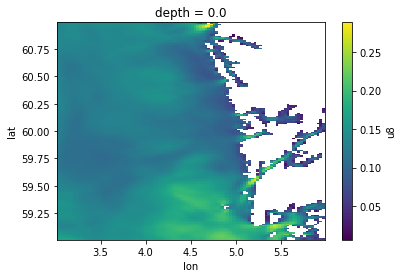

In [100]:
u8.unstack('z').std(dim='time').plot()

In [101]:
tmp=NWSs.copy()

In [108]:
u8.attrs['standard_name']='interpolated from Norkyst 800'
v8.attrs['standard_name']='interpolated from Norkyst 800'

In [111]:
NWSs['u8']=u8
NWSs['v8']=v8


In [112]:
NWSs

<xarray.Dataset>
Dimensions:  (time: 1464, z: 10678)
Coordinates:
    depth    float32 0.0
  * time     (time) datetime64[ns] 2021-06-01 ... 2021-07-31T23:00:00
  * z        (z) MultiIndex
  - lat      (z) float64 59.01 59.01 59.01 59.01 ... 60.99 60.99 60.99 60.99
  - lon      (z) float64 3.03 3.061 3.091 3.121 ... 4.667 4.727 4.758 4.788
    mn       (z) float64 -0.02152 -0.01742 -0.01452 ... -0.1086 -0.1751 -0.03144
Data variables:
    vo       (time, z) float32 -0.028 0.001 0.065 0.143 ... -0.24 -0.425 -0.377
    uo       (time, z) float32 0.031 0.008 0.011 0.024 ... -0.075 -0.272 -0.222
    u8       (time, z) float32 0.2114 0.2351 0.259 ... -0.3527 -0.3857 -0.2353
    v8       (time, z) float32 -0.05621 -0.0539 -0.06316 ... -0.6569 -0.3171
Attributes: (12/15)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    _CoordSysBuilder:     ucar.nc2.dataset.conv.CF1Convention
    comment:

In [113]:
NWSs.unstack('z').to_netcdf('Data/2021/both_focused.nc')

## Read combined focused

In [2]:
all=xr.open_dataset('Data/2021/both_focused.nc').stack(z=['lon','lat']).dropna(dim='z').load()
all.close()


In [3]:
all=all.drop('depth')

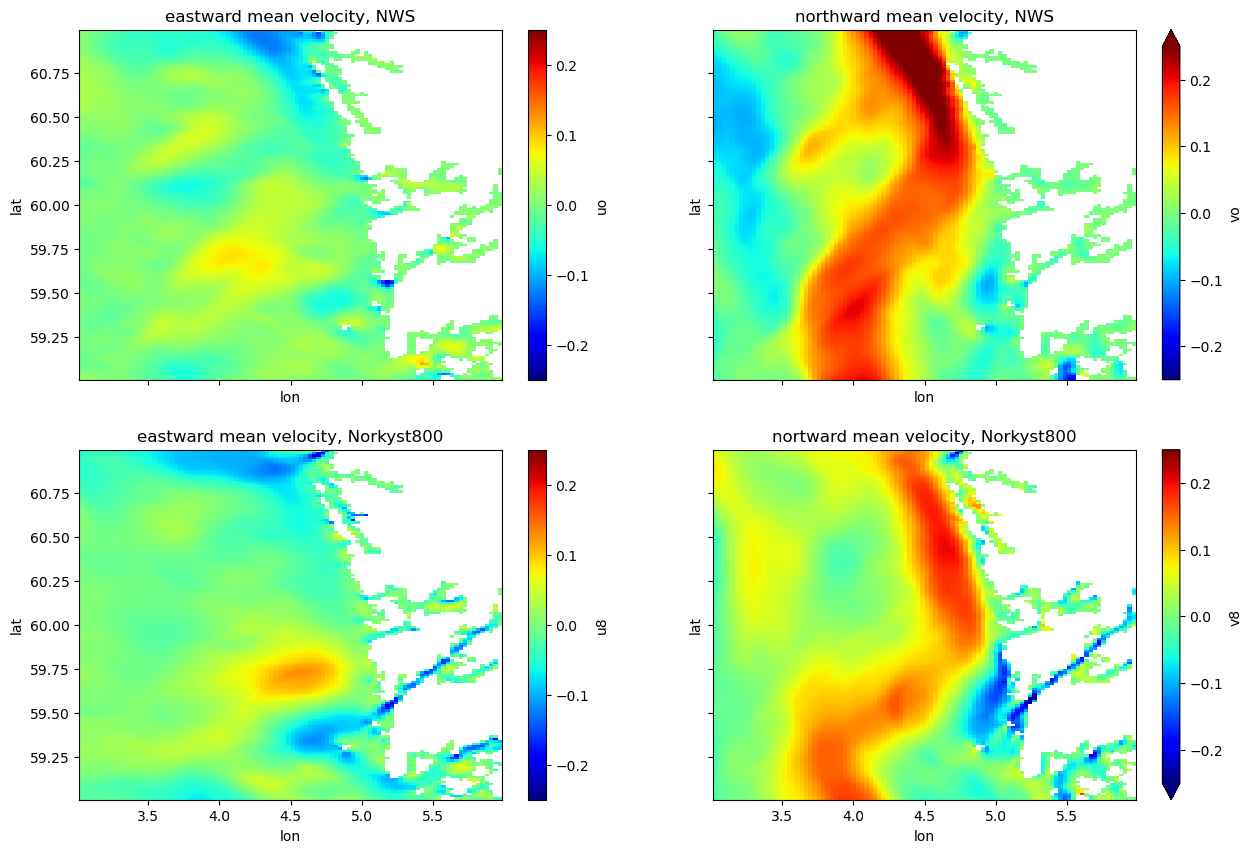

In [4]:
vmin=-0.25
vmax=0.25
cmap='jet'
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10),sharex=True,sharey=True)
all.uo.mean(dim='time').unstack('z').plot(x='lon',y='lat',vmin=vmin,vmax=vmax,cmap=cmap,ax=axes[0,0])
all.vo.mean(dim='time').unstack('z').plot(x='lon',y='lat',vmin=vmin,vmax=vmax,cmap=cmap,ax=axes[0,1])
all.u8.mean(dim='time').unstack('z').plot(x='lon',y='lat',vmin=vmin,vmax=vmax,cmap=cmap,ax=axes[1,0])
all.v8.mean(dim='time').unstack('z').plot(x='lon',y='lat',vmin=vmin,vmax=vmax,cmap=cmap,ax=axes[1,1])

axes[0,0].title.set_text('eastward mean velocity, NWS')
axes[0,1].title.set_text('northward mean velocity, NWS')
axes[1,0].title.set_text('eastward mean velocity, Norkyst800')
axes[1,1].title.set_text('nortward mean velocity, Norkyst800')

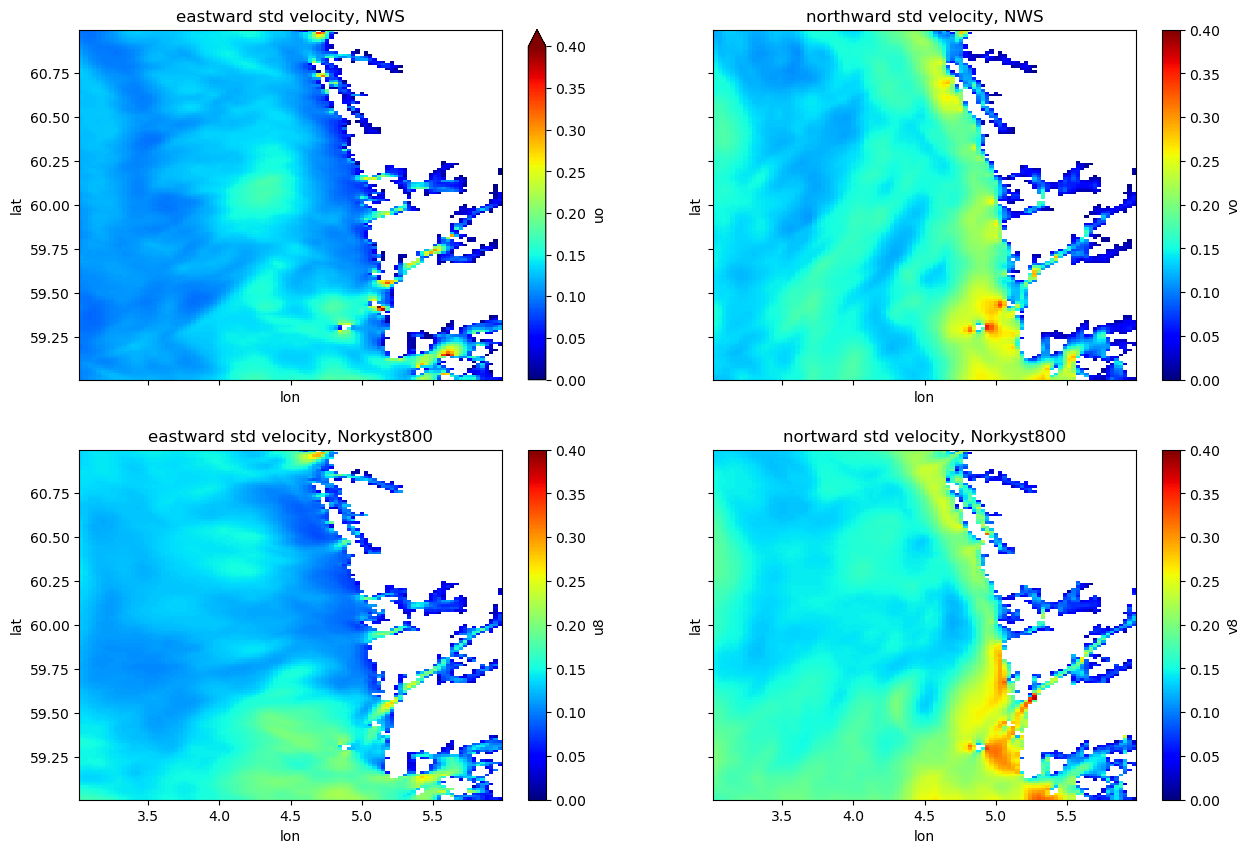

In [5]:
vmin=0
vmax=0.4
cmap='jet'
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10),sharex=True,sharey=True)
all.uo.std(dim='time').unstack('z').plot(x='lon',y='lat',vmin=vmin,vmax=vmax,cmap=cmap,ax=axes[0,0])
all.vo.std(dim='time').unstack('z').plot(x='lon',y='lat',vmin=vmin,vmax=vmax,cmap=cmap,ax=axes[0,1])
all.u8.std(dim='time').unstack('z').plot(x='lon',y='lat',vmin=vmin,vmax=vmax,cmap=cmap,ax=axes[1,0])
all.v8.std(dim='time').unstack('z').plot(x='lon',y='lat',vmin=vmin,vmax=vmax,cmap=cmap,ax=axes[1,1])

axes[0,0].title.set_text('eastward std velocity, NWS')
axes[0,1].title.set_text('northward std velocity, NWS')
axes[1,0].title.set_text('eastward std velocity, Norkyst800')
axes[1,1].title.set_text('nortward std velocity, Norkyst800')

In [6]:
def norm_all(data):
    return ((data-data.mean(dim='time'))/data.std(dim='time')).data
def corr_all(data,comp='u'):
    out= (norm_all(data[comp+'o']).T@norm_all(data[comp+'8']))/(data.dims['time']-1)
    return out.diagonal()

In [16]:
tmp=corr_all(all,'u')

In [17]:
tmp

array([0.54715693, 0.552614  , 0.55192477, ..., 0.31055686, 0.28978336,
       0.1562399 ], dtype=float32)

In [7]:
all['corru']=('z',corr_all(all,'u'))
all['corrv']=('z',corr_all(all,'v'))


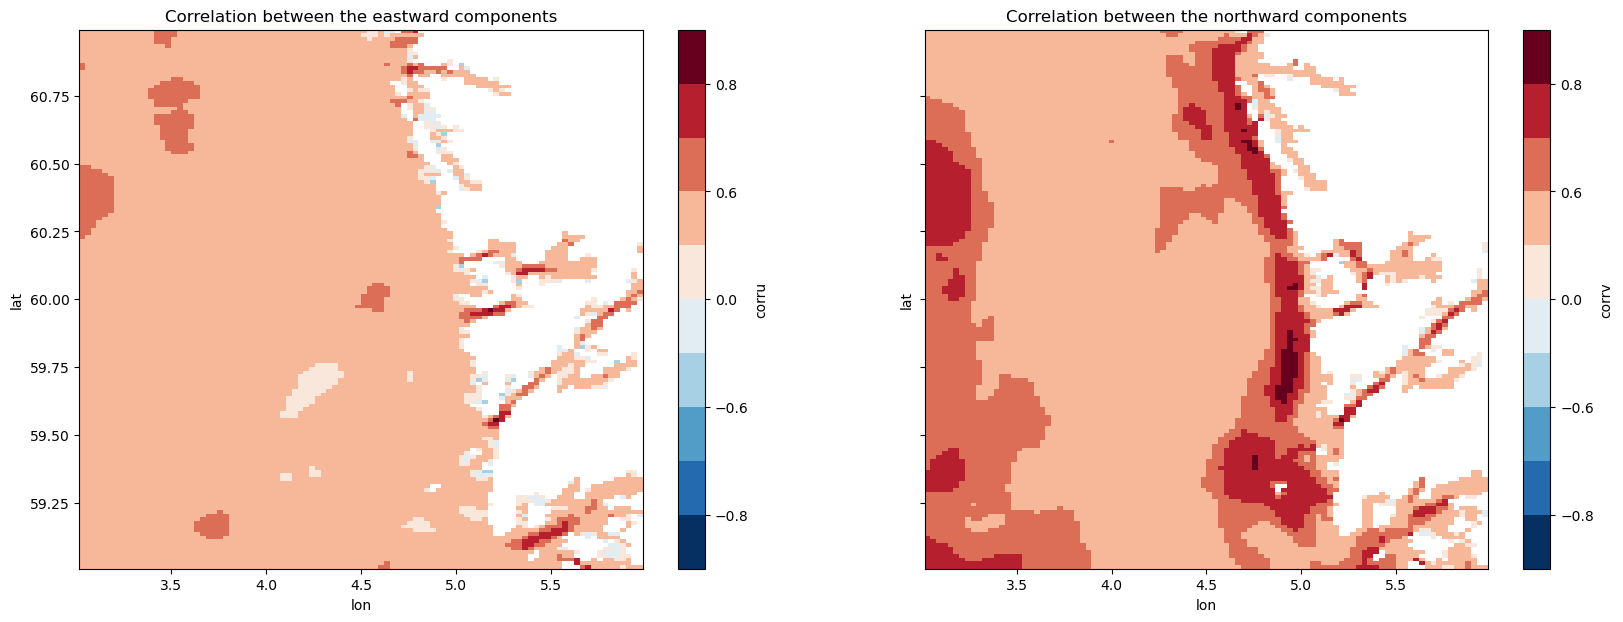

In [8]:
levels=[0.9,0.8,0.7,0.6,0.2,0.,-0.2,-0.6,-0.7,-0.8,-0.9]
vmax=1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7),sharex=True,sharey=True)
all.corru.unstack('z').plot(x='lon', y='lat',vmax=vmax,ax=axes[0],levels=levels)
all.corrv.unstack('z').plot(x='lon', y='lat',vmax=vmax, ax=axes[1],levels=levels)
axes[0].title.set_text('Correlation between the eastward components')
axes[1].title.set_text('Correlation between the northward components')

### Windroses

In [9]:
from math import atan2
def calc_speed_dir(u,v):
    speed=xr.DataArray(data=None,coords=u.coords)
    dir=xr.DataArray(data=None,coords=u.coords)
    speed = np.sqrt(u.values*u.values + v.values**2)
    dir = np.arctan2(v.data, u.data)*180/np.pi 
    dir[dir<0] += 360
    return speed, dir

In [10]:

sp,dr=calc_speed_dir(all.uo,all.vo)
all['dir0']=(('time','z'),dr)
all['speed0']=(('time','z'),sp)
sp,dr=calc_speed_dir(all.u8,all.v8)
all['dir8']=(('time','z'),dr)
all['speed8']=(('time','z'),sp)

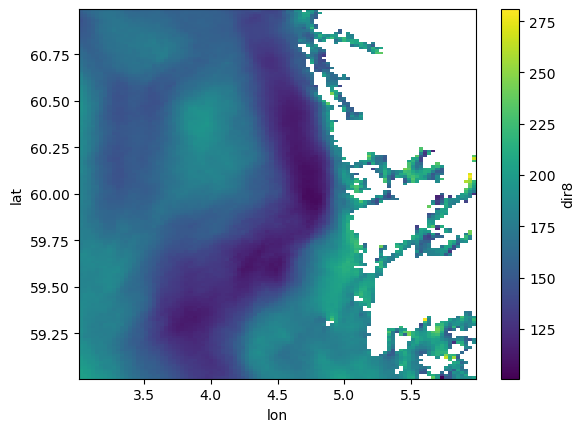

In [11]:
all.dir8.mean(dim='time').unstack('z').plot(x='lon',y='lat')

In [14]:
all.dir8.max()

<xarray.DataArray 'dir8' ()>
array(359.99990845)

In [ ]:
#ws0=all['speed0'].unstack('z').sel(lat=lat,lon=lon,method='nearest')
#wd0=all['dir0'].unstack('z').sel(lat=lat,lon=lon,method='nearest')
#ws8=all['speed8'].unstack('z').sel(lat=lat,lon=lon,method='nearest')
#wd8=all['dir8'].unstack('z').sel(lat=lat,lon=lon,method='nearest')

In [21]:

ax = WindroseAxes.from_ax()
ax.bar(wd0.data, ws0.data, normed=True, opening=0.8, edgecolor="white")
ax.set_legend()
ax.set_xticklabels(['N', 'NW',  'W', 'SW', 'S', 'SE','E', 'NE'])
ax.set_theta_zero_location('N')

NameError: name 'WindroseAxes' is not defined

In [19]:
tmp=all.unstack('z')

In [43]:
tmp

<xarray.Dataset>
Dimensions:  (lon: 98, lat: 147, time: 1464)
Coordinates:
  * lon      (lon) float64 3.03 3.061 3.091 3.121 ... 5.879 5.909 5.939 5.97
  * lat      (lat) float64 59.01 59.03 59.04 59.05 ... 60.95 60.96 60.97 60.99
  * time     (time) datetime64[ns] 2021-06-01 ... 2021-07-31T23:00:00
    mn       (lon, lat) float64 -0.02152 -0.02312 -0.02433 ... nan nan nan
Data variables:
    vo       (time, lon, lat) float32 -0.028 -0.008 0.017 0.05 ... nan nan nan
    uo       (time, lon, lat) float32 0.031 0.033 0.043 0.061 ... nan nan nan
    u8       (time, lon, lat) float32 0.2114 0.2112 0.2149 ... nan nan nan
    v8       (time, lon, lat) float32 -0.05621 -0.07763 -0.07992 ... nan nan nan
    corru    (lon, lat) float32 0.5472 0.5526 0.5519 0.5539 ... nan nan nan nan
    corrv    (lon, lat) float32 0.7445 0.7518 0.7548 0.7497 ... nan nan nan nan
    dir0     (time, lon, lat) float32 317.9 346.4 21.57 39.34 ... nan nan nan
    speed0   (time, lon, lat) float32 0.04177 0.03396 0.04624 ... nan nan nan
    dir8     (time, lon, lat) float32 345.1 339.8 339.6 344.8 ... nan nan nan
    speed8   (time, lon, lat) float32 0.2188 0.225 0.2292 0.2182 ... nan nan nan
Attributes: (12/15)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    _CoordSysBuilder:     ucar.nc2.dataset.conv.CF1Convention
    comment:

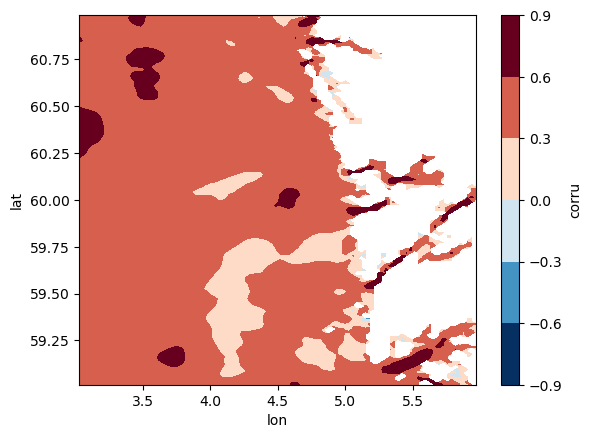

In [38]:
tmp.corru.plot.contourf(x='lon',y='lat')

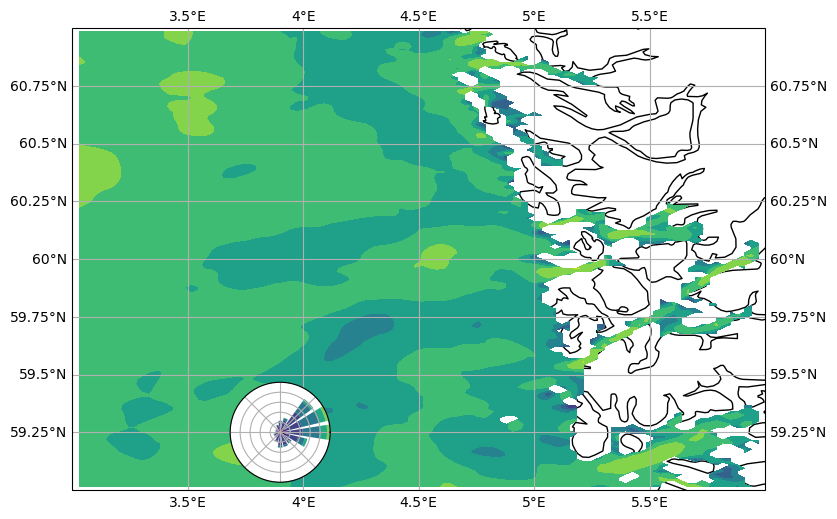

In [60]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import windrose




minlon, maxlon, minlat, maxlat = (3, 6, 59, 61)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 6))


# Draw main ax on top of which we will add windroses
main_ax = fig.add_subplot(1, 1, 1, projection=proj)


main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)


main_ax.gridlines(draw_labels=True)
main_ax.coastlines('10m')#,alpha=0.1)
#main_ax.stock_img();
#request = cimgt.OSM()
#main_ax.add_image(request, 12)

#filled_c = main_ax.contourf(x=tmp.lon.data, y=tmp.lat.data, z=tmp.corru.data, transform=ccrs.PlateCarree())

# Coordinates of the station we were measuring windspeed
plt.contourf(tmp.lon.data,tmp.lat.data,tmp.corru.data.T,transform=ccrs.PlateCarree())
cham_lon, cham_lat = (lon, lat)
#passy_lon, passy_lat = (6.7, 45.9159)

# Inset axe it with a fixed size
wrax_cham = inset_axes(
    main_ax,
    width=1,  # size in inches
    height=1,  # size in inches
    loc="center",  # center bbox at given position
    bbox_to_anchor=(cham_lon, cham_lat),  # position of the axe
    bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
    axes_class=windrose.WindroseAxes,  # specify the class of the axe
)

# Inset axe with size relative to main axe
height_deg = 0.1
# wrax_passy = inset_axes(
#     main_ax,
#     width="100%",  # size in % of bbox
#     height="100%",  # size in % of bbox
#     # loc="center",  # don"t know why, but this doesn"t work.
#     # specify the center lon and lat of the plot, and size in degree
#     bbox_to_anchor=(
#         passy_lon - height_deg / 2,
#         passy_lat - height_deg / 2,
#         height_deg,
#         height_deg,
#     ),
#     bbox_transform=main_ax.transData,
#     axes_class=windrose.WindroseAxes,
# )

wrax_cham.bar(wd8, ws8)
#wrax_passy.bar(wd, ws)
for ax in [wrax_cham]:#, wrax_passy]:
    ax.tick_params(labelleft=False, labelbottom=False)

fig.show()

In [53]:
np.shape(tmp.lat)

(147,)

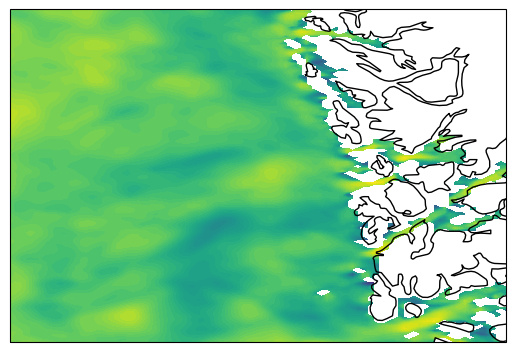

In [55]:
import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np

from cartopy import config
import cartopy.crs as ccrs


# get the path of the file. It can be found in the repo data directory.
fname = os.path.join(config["repo_data_dir"],
                     'netcdf', 'HadISST1_SST_update.nc'
                     )

dataset = netcdf_dataset(fname)
sst = dataset.variables['sst'][0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(tmp.lon, tmp.lat, tmp.corru.T, 60,
             transform=ccrs.PlateCarree())

ax.coastlines('10m')

plt.show()

In [12]:
def GA_get_wdws(indata,lat=59.25,lon=3.9,model='0'):
    ws=indata['speed'+model].unstack('z').sel(lat=lat,lon=lon,method='nearest')
    wd=indata['dir'+model].unstack('z').sel(lat=lat,lon=lon,method='nearest')
    return ws, wd
    


In [14]:
lats=[59.5,59.5, 60., 60., 60.5]
np.arange(0,len(lats))

array([0, 1, 2, 3, 4])

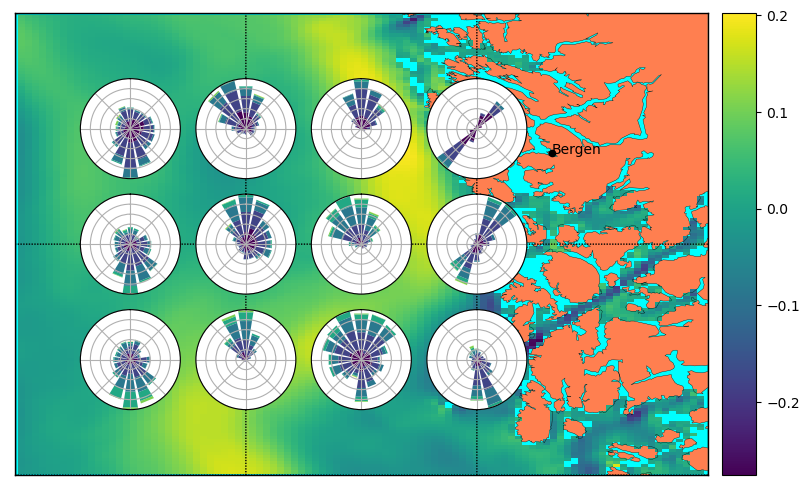

In [24]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import windrose
import numpy as np
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

llcrnrlon = 3.
llcrnrlat=59. 
urcrnrlon=6
urcrnrlat=61.

lat_0=(urcrnrlat+llcrnrlat)/2
lon_0=(urcrnrlon+llcrnrlon)/2

map = Basemap(resolution='h',projection='cyl',lat_0=lat_0,lon_0=lon_0,llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='coral',lake_color='aqua')
#The latitude of New Orleans, LA, USA is 29.951065, and the longitude is -90.071533.
x, y = map( 5.32415,60.39299) # Houston
plt.scatter(x, y, 20, marker='o', color='Black')
plt.annotate('Bergen', xy=(x, y))   

xx, yy = np.meshgrid(tmp.lon.data, tmp.lat.data)
zz=tmp.v8.mean(dim='time').data.T
map.pcolormesh(xx,yy,zz)
map.colorbar()
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(3,6,1))
map.drawparallels(np.arange(59,61,1))

lats=[59.5,60.,60.5]
lons=[3.5,4., 4.5,5.]
for lat in lats:  #np.arange(0,len(lats)):
    #lat=lats[ii]
    #lon=lons[ii]
    for lon in lons:
        wrax_cham = inset_axes(
            ax,
            width=1,  # size in inches
            height=1,  # size in inches
            loc="center",  # center bbox at given position
            bbox_to_anchor=(lon, lat),  # position of the axe
            bbox_transform=ax.transData,  # use data coordinate (not axe coordinate)
            axes_class=windrose.WindroseAxes,  # specify the class of the axe
            )
        ws,wd= GA_get_wdws(all,lat=lat,lon=lon,model='0')
        wrax_cham.bar(wd, ws)
        wrax_cham.set_xticklabels(['N', 'NW',  'W', 'SW', 'S', 'SE','E', 'NE'])
        wrax_cham.set_theta_zero_location('N')
        wrax_cham.tick_params(labelleft=False, labelbottom=False)

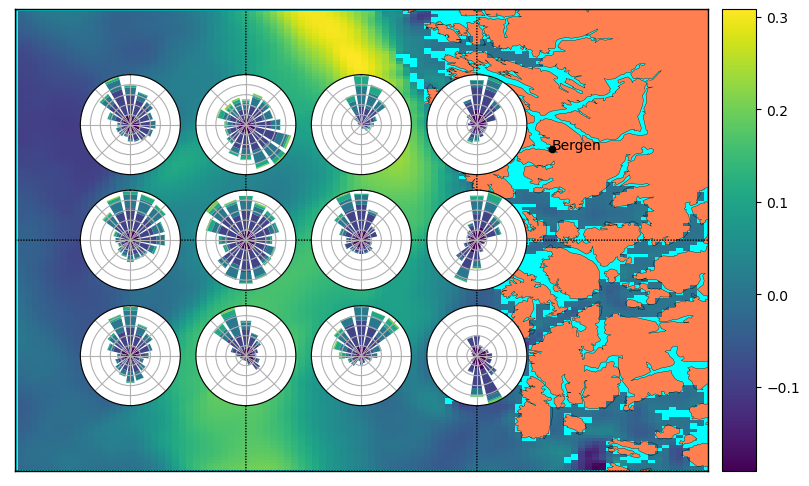

In [25]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import windrose
import numpy as np
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

llcrnrlon = 3.
llcrnrlat=59. 
urcrnrlon=6
urcrnrlat=61.

lat_0=(urcrnrlat+llcrnrlat)/2
lon_0=(urcrnrlon+llcrnrlon)/2

map = Basemap(resolution='h',projection='cyl',lat_0=lat_0,lon_0=lon_0,llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='coral',lake_color='aqua')
#The latitude of New Orleans, LA, USA is 29.951065, and the longitude is -90.071533.
x, y = map( 5.32415,60.39299) # Houston
plt.scatter(x, y, 20, marker='o', color='Black')
plt.annotate('Bergen', xy=(x, y))   

xx, yy = np.meshgrid(tmp.lon.data, tmp.lat.data)
zz=tmp.vo.mean(dim='time').data.T
map.pcolormesh(xx,yy,zz)
map.colorbar()
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(3,6,1))
map.drawparallels(np.arange(59,61,1))

lats=[59.5,60.,60.5]
lons=[3.5,4., 4.5,5.]
for lat in lats:  #np.arange(0,len(lats)):
    #lat=lats[ii]
    #lon=lons[ii]
    for lon in lons:
        wrax_cham = inset_axes(
            ax,
            width=1,  # size in inches
            height=1,  # size in inches
            loc="center",  # center bbox at given position
            bbox_to_anchor=(lon, lat),  # position of the axe
            bbox_transform=ax.transData,  # use data coordinate (not axe coordinate)
            axes_class=windrose.WindroseAxes,  # specify the class of the axe
            )
        ws,wd= GA_get_wdws(all,lat=lat,lon=lon,model='8')
        wrax_cham.bar(wd, ws)
        wrax_cham.set_xticklabels(['N', 'NW',  'W', 'SW', 'S', 'SE','E', 'NE'])
        wrax_cham.set_theta_zero_location('N')
        wrax_cham.tick_params(labelleft=False, labelbottom=False)

In [ ]:

# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))
# make up some data on a regular lat/lon grid.
nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)
lats = tmp.lats(0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])
wave = 0.75*(np.sin(2.*lats)**8*np.cos(4.*lons))
mean = 0.5*np.cos(2.*lats)*((np.sin(2.*lats))**2 + 2.)
# compute native map projection coordinates of lat/lon grid.
x, y = map(lons*180./np.pi, lats*180./np.pi)
# contour data over the map.
cs = map.contour(x,y,wave+mean,15,linewidths=1.5)
plt.title('contour lines over filled continent background')
plt.show()